# Improvements from the pretraining strategy
## Reduction in training runtime

In this notebook we take a look at how much time we gain by pretraining BioBLP with a cheaper RotatE model.

In [32]:
import matplotlib.pyplot as plt
import pandas as pd
import wandb

In [62]:
# Configure matplotlib fonts to use Helvetica Neue
plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['font.sans-serif'] = 'Helvetica Neue'

---

We will fetch the training data directly from Weights & Biases.

In [ ]:
api = wandb.Api()

In [47]:
def get_run_data(run_id: str):
    run = api.run(f'/discoverylab/bioblp/runs/{run_id}')
    losses = run.history(pandas=True)
    losses = losses[['loss', '_runtime', 'validation.both.realistic.inverse_harmonic_mean_rank']]
    losses = pd.concat([pd.DataFrame({'loss': [0], '_runtime': [0], 'validation.both.realistic.inverse_harmonic_mean_rank': [0]}), losses], ignore_index=True)
    losses = losses.rename(columns={"validation.both.realistic.inverse_harmonic_mean_rank": "MRR"})
    losses.dropna(inplace=True)
    losses["_runtime_h"] = losses["_runtime"] / 3600

    return losses

rotate_data = get_run_data('36viovqn')
bioblp_pretrained_data = get_run_data('38uz9fjs')
bioblp_base_data = get_run_data('1hh20k34')

To show the total time, we have to add the times of both RotatE and BioBLP-D.

In [48]:
rotate_runtime = rotate_data['_runtime_h'].iloc[-1]
bioblp_pretrained_data_shifted = bioblp_pretrained_data.copy()
bioblp_pretrained_data_shifted["_runtime_h"] = bioblp_pretrained_data_shifted["_runtime_h"] + rotate_runtime
# Concatenate rotate_data and bioblp_pretrained_data_shifted
rotate_bioblp_pretrained_data = pd.concat([rotate_data, bioblp_pretrained_data_shifted.iloc[1:]], axis=0)

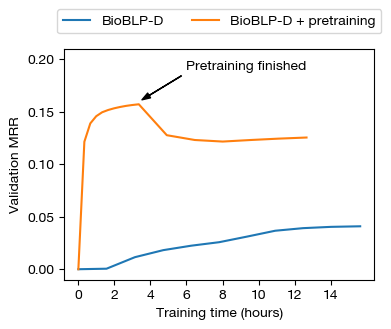

In [108]:
# Plot rotate_data
fig, ax = plt.subplots(figsize=(4, 3))
ax.plot(bioblp_base_data["_runtime_h"], bioblp_base_data["MRR"], label="BioBLP-D")
ax.plot(rotate_bioblp_pretrained_data["_runtime_h"], rotate_bioblp_pretrained_data["MRR"], label="BioBLP-D + pretraining")

# Show legend
ax.legend()
ax.set_ylim(-0.01, 0.21)
# Set ticks every 1 hour
ax.set_xticks(range(0, 16, 2));
ax.set_xlabel('Training time (hours)')
ax.set_ylabel('Validation MRR')
# Put legend above plot
ax.legend(loc='upper center', bbox_to_anchor=(0.5, 1.2), ncol=2)
# Add an arrow to indicate where pretraining is finished
ax.annotate('Pretraining finished', xy=(3.4, 0.16), xytext=(6, 0.19),
            arrowprops=dict(facecolor='black', shrink=0.05, width=0.1, headwidth=4, headlength=6));

In [109]:
fig.savefig('pretraining-runtime.pdf', bbox_inches='tight')